In [146]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from utils import make_spiral, plot_data, plot_decision_boundary, plot_training_progress, plot_decision_boundary_roundwise

## **Set Up the Dataset**

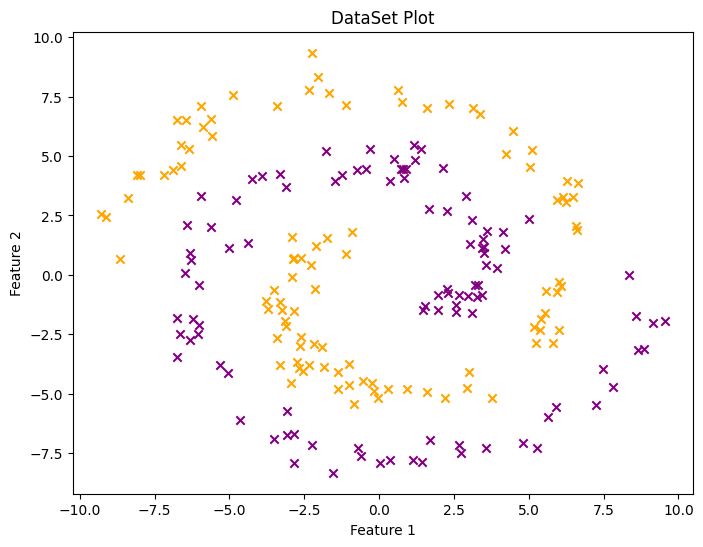

In [147]:
# Generate and plot the dataset
X, y = make_spiral(n_samples=100)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
plot_data(X, y)

# **Q1:**
*Implement and train a neural network on the dataset generated above. You are free to use any network architecture you think is useful. Finally, plot the decision boundary generated by your model.*

The training of a neural network can be devided into the following steps:
1. Initialization of the parameters W[1], b[1], W[2], b[2], . . .
2. Computation of the forward pass
(i. e. compute the activations of the network for a batch of training examples)
3. Evaluate the loss function based on the true labels
4. Propagate the error gradients backwards through the network and update the
parameters (this step is referred to as backpropagation)
5. Update the weights using the gradient descent update rule

> -> Steps (2) to (5) are repeated until the network performs satisfactorily or until a fixed
number of iterations specified in advance has been performed

### **Setting Up PyTorch & Data-Set**

<div class="alert alert-block alert-success">
<b>Up to you:</b> Using the correct Resources for Trining could improve the Trainin Speed and Performance of the Model.
</div>

In [148]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


#### Dataset and DataLoader

In PyTorch Datasets and Dataloader can be used for better Performance:

**Dataset-Klasse:**
- Diese Klasse dient dazu, den Datensatz in einer Art Container zu verpacken, den PyTorch dann verarbeiten kann.
- Die Klasse SpiralDataset erbt von torch.utils.data.Dataset, einer abstrakten Klasse, die genau die zwei Methoden __len__() und __getitem__() implementiert.
- __init__() wird verwendet, um die Daten (Features X und Labels y) zu speichern, wobei sie in Torch-Tensoren umgewandelt werden, was notwendig ist, um sie in PyTorch weiter bearbeiten zu können.
- __len__() gibt die Anzahl der Datenpunkte im Datensatz zurück.
- __getitem__() gibt einen einzelnen Datenpunkt zurück, bestehend aus einem Feature-Vektor und einem Label, basierend auf einem gegebenen Index.

**DataLoader:**
- Der DataLoader ist verantwortlich für das Laden von Daten in Batches und das Shufflen der Daten, falls erwünscht.
- PyTorch's *DataLoader* übernimmt die Aufgabe, die Daten effizient zu laden und stapelweise zu verarbeiten, wodurch das Training beschleunigt wird.
- *DataLoader(dataset, batch_size=32, shuffle=True)* erstellt einen DataLoader, der die Daten aus dem dataset in Batches von 32 Beispielpunkten lädt und die Daten vor jedem Epoche-Training mischt.

In [149]:
# Define Dataset and DataLoader
class SpiralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SpiralDataset(X, y)
dataloader = DataLoader(dataset, batch_size=300, shuffle=True) # Bacht size of 1 -> Stochastic Gradient Descent (SGD)

### **Design the Model and intialize the Parameters**

The Parameters are inititalized normal-ditributet around 0

In [150]:
# Step 4: Define the Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer_1 = nn.Linear(2, 10)
        self.hidden_layer_2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 2)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.softmax(self.output_layer(x))
        return x

**Alternative: Pipeline-Architektur**

Eine alternative Methode ist die Verwendung von nn.Sequential, um eine Pipeline-Architektur zu definieren. nn.Sequential erlaubt es, die Layer eines Modells in der Reihenfolge zu spezifizieren, in der die Daten durch diese fließen, ohne eine explizite forward()-Methode zu definieren:

In [151]:
# model = nn.Sequential(
# nn.Linear(2, 10),
# nn.ReLU(),
# nn.Linear(10, 10),
# nn.ReLU(),
# nn.Linear(10, 2)
# )

In [152]:
# Step 5: Instantiate the model, define the loss function and optimizer
model = NeuralNetwork()

### **Perform a singel forward Pass:**

(And Evaluate the Results)

In [153]:
# Perfrom one forward pass to check the model:
with torch.no_grad():
    sample_input = torch.tensor(X[:5], dtype=torch.float32)
    sample_output = model(sample_input)
    labels = torch.argmax(sample_output, dim=1)
    #criterion_output = criterion(sample_output, torch.tensor([0], dtype=torch.long))
    print(f"Sample input: {sample_input}, Sample output: {sample_output}, Resulting Label: {labels}" )#, Loss: {criterion_output.item()}")

Sample input: tensor([[-1.7769,  5.2217],
        [ 8.6473, -3.1784],
        [-2.2482, -7.1489],
        [-6.6416, -2.4775],
        [ 4.2191,  1.0704]]), Sample output: tensor([[0.5038, 0.4962],
        [0.5021, 0.4979],
        [0.5061, 0.4939],
        [0.5037, 0.4963],
        [0.5047, 0.4953]]), Resulting Label: tensor([0, 0, 0, 0, 0])


<Axes: title={'center': 'Decision Boundary'}, xlabel='Feature 1', ylabel='Feature 2'>

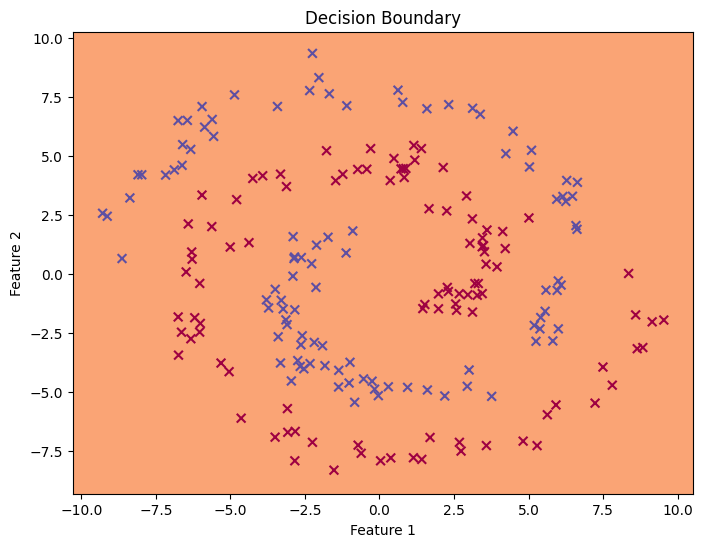

In [154]:
plot_decision_boundary(model, X, y)

### **Perform a singel Backpropagation**

#### Backpropagation Erklärung

##### Forward Pass

Die Berechnung der Aktivierung und des Outputs eines Neurons erfolgt wie folgt:

$$
z = w \cdot x + b
$$

mittels einer Aktivierungsfunktion, zum Beispiel ReLU:

$$
\text{ReLU}(x) = \max(0, x)
$$

##### Loss Funktion

Für die Verlustberechnung verwenden wir die Cross-Entropy:

$$
\text{Loss}(y, \hat{y}) = -\sum_{i} y_i \log(\hat{y}_i)
$$

##### Backward Pass

Berechnungen der Gradienten mit Bezug zur Verlustfunktion durch das Netzwerk:

$$
\frac{\partial L}{\partial w} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial w}
$$

##### Parameter-Update

Aktualisieren der Gewichte:

$$
w = w - \eta \frac{\partial L}{\partial w}
$$


In [155]:
# Show updated parameters
for name, param in model.named_parameters():
    print(f"\nOld parameters for {name}:\n", param.data)


Old parameters for hidden_layer_1.weight:
 tensor([[-0.0142,  0.0659],
        [ 0.0261,  0.0689],
        [-0.0156,  0.0056],
        [-0.0376, -0.0160],
        [-0.0817, -0.0301],
        [ 0.0719,  0.1102],
        [-0.0793, -0.0966],
        [ 0.0146,  0.0473],
        [-0.0201,  0.0827],
        [-0.0922,  0.2283]])

Old parameters for hidden_layer_1.bias:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Old parameters for hidden_layer_2.weight:
 tensor([[ 0.0056,  0.0639, -0.1038, -0.0793, -0.0859, -0.0318, -0.1227, -0.1433,
          0.0183,  0.1432],
        [-0.0472,  0.0305,  0.1651, -0.0712,  0.1563, -0.0804, -0.0902,  0.0297,
         -0.0693,  0.0141],
        [-0.1456,  0.0291,  0.0380,  0.1160,  0.0085,  0.0686, -0.1151, -0.0375,
         -0.1382, -0.1669],
        [ 0.0290,  0.0407, -0.1810, -0.0459, -0.0917,  0.0969, -0.0352, -0.2039,
          0.0107,  0.0339],
        [-0.0115, -0.0355,  0.1732, -0.0987,  0.0866, -0.0496, -0.0341, -0.1253,
          0.0431, -0.07

In [156]:
batch_X, batch_y = next(iter(dataloader))

# Perform a single forward pass
output_logits = model(batch_X)
print("Output logits:\n", output_logits)

# Calculate the loss
criterion = nn.CrossEntropyLoss()
loss = criterion(output_logits, batch_y)
print("\nLoss:\n", loss.item())

# Compute gradients (backward pass)
model.zero_grad()  # Clear previous gradients
loss.backward()    # Compute gradients

# Display gradients for each layer
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"\nGradients for {name}:\n", param.grad)

# Update Weights
# Normally done by optimizer, here for visualization only

learning_rate = 0.01
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Show updated parameters
for name, param in model.named_parameters():
    print(f"\nUpdated parameters for {name}:\n", param.data)

Output logits:
 tensor([[0.5035, 0.4965],
        [0.5030, 0.4970],
        [0.5009, 0.4991],
        [0.5023, 0.4977],
        [0.5028, 0.4972],
        [0.5040, 0.4960],
        [0.5060, 0.4940],
        [0.5003, 0.4997],
        [0.5007, 0.4993],
        [0.5048, 0.4952],
        [0.5070, 0.4930],
        [0.5049, 0.4951],
        [0.5056, 0.4944],
        [0.5056, 0.4944],
        [0.5040, 0.4960],
        [0.5024, 0.4976],
        [0.5030, 0.4970],
        [0.5040, 0.4960],
        [0.5012, 0.4988],
        [0.5042, 0.4958],
        [0.5036, 0.4964],
        [0.5000, 0.5000],
        [0.5044, 0.4956],
        [0.5062, 0.4938],
        [0.5050, 0.4950],
        [0.5060, 0.4940],
        [0.5077, 0.4923],
        [0.5036, 0.4964],
        [0.5056, 0.4944],
        [0.5021, 0.4979],
        [0.5033, 0.4967],
        [0.5044, 0.4956],
        [0.5087, 0.4913],
        [0.5019, 0.4981],
        [0.5054, 0.4946],
        [0.5033, 0.4967],
        [0.5028, 0.4972],
        [0.5014, 0.498

<Axes: title={'center': 'Decision Boundary'}, xlabel='Feature 1', ylabel='Feature 2'>

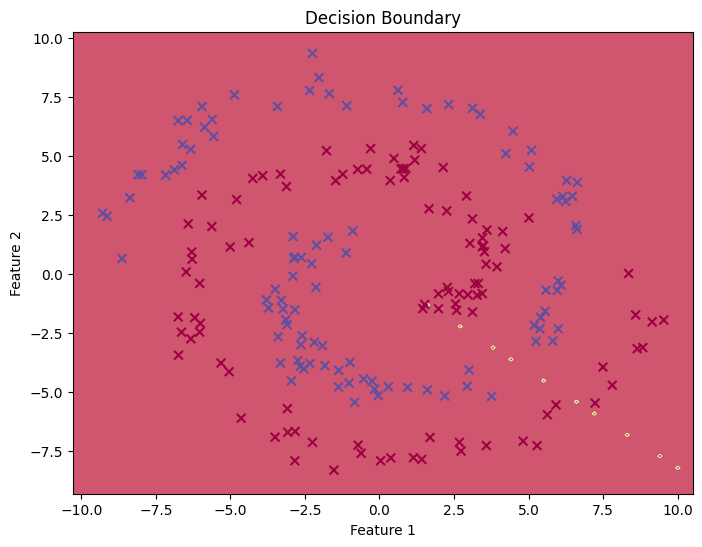

In [157]:
plot_decision_boundary(model, X, y)

### **Ittearate the Training**

In [158]:
# Funktion to perform the training of the model
def train_model(model, learning_rate=0.01, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=100, plot_interval=10):
    criterion = loss_fn()
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []

    # Set up for plotting
    num_plots = num_epochs // plot_interval
    fig, axes = plt.subplots(nrows=num_plots//2, ncols=2, figsize=(12, 6 * (num_plots//2)))

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0

        for batch_X, batch_y in dataloader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                predictions = torch.argmax(y_pred, dim=1)
                correct += (predictions == batch_y).sum().item()

        train_loss.append(epoch_loss / len(dataloader))
        accuracy = correct / len(dataset)
        train_acc.append(accuracy * 100)

        # Plot interval
        if (epoch + 1) % plot_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss[-1]:.4f}, Accuracy: {train_acc[-1]:.2f}%")
            ax_index = (epoch // plot_interval) // 2, (epoch // plot_interval) % 2
            plot_decision_boundary_roundwise(model, X_tensor, y_tensor, axes[ax_index])

    # Plot final metrics with dual axes
    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color=color)
    ax1.plot(train_loss, color=color, label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Train Accuracy (%)', color=color)
    ax2.plot(train_acc, color=color, label='Train Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and legends
    fig.suptitle('Training Loss and Accuracy')
    fig.tight_layout()  # For a cleaner layout
    plt.show()

    return model

Epoch [100/1000], Loss: 0.6425, Accuracy: 68.00%
Epoch [200/1000], Loss: 0.4688, Accuracy: 93.00%
Epoch [300/1000], Loss: 0.3863, Accuracy: 95.50%
Epoch [400/1000], Loss: 0.3640, Accuracy: 97.00%
Epoch [500/1000], Loss: 0.3429, Accuracy: 99.00%
Epoch [600/1000], Loss: 0.3350, Accuracy: 99.50%
Epoch [700/1000], Loss: 0.3359, Accuracy: 99.50%
Epoch [800/1000], Loss: 0.3269, Accuracy: 99.50%
Epoch [900/1000], Loss: 0.3240, Accuracy: 99.50%
Epoch [1000/1000], Loss: 0.3226, Accuracy: 99.50%


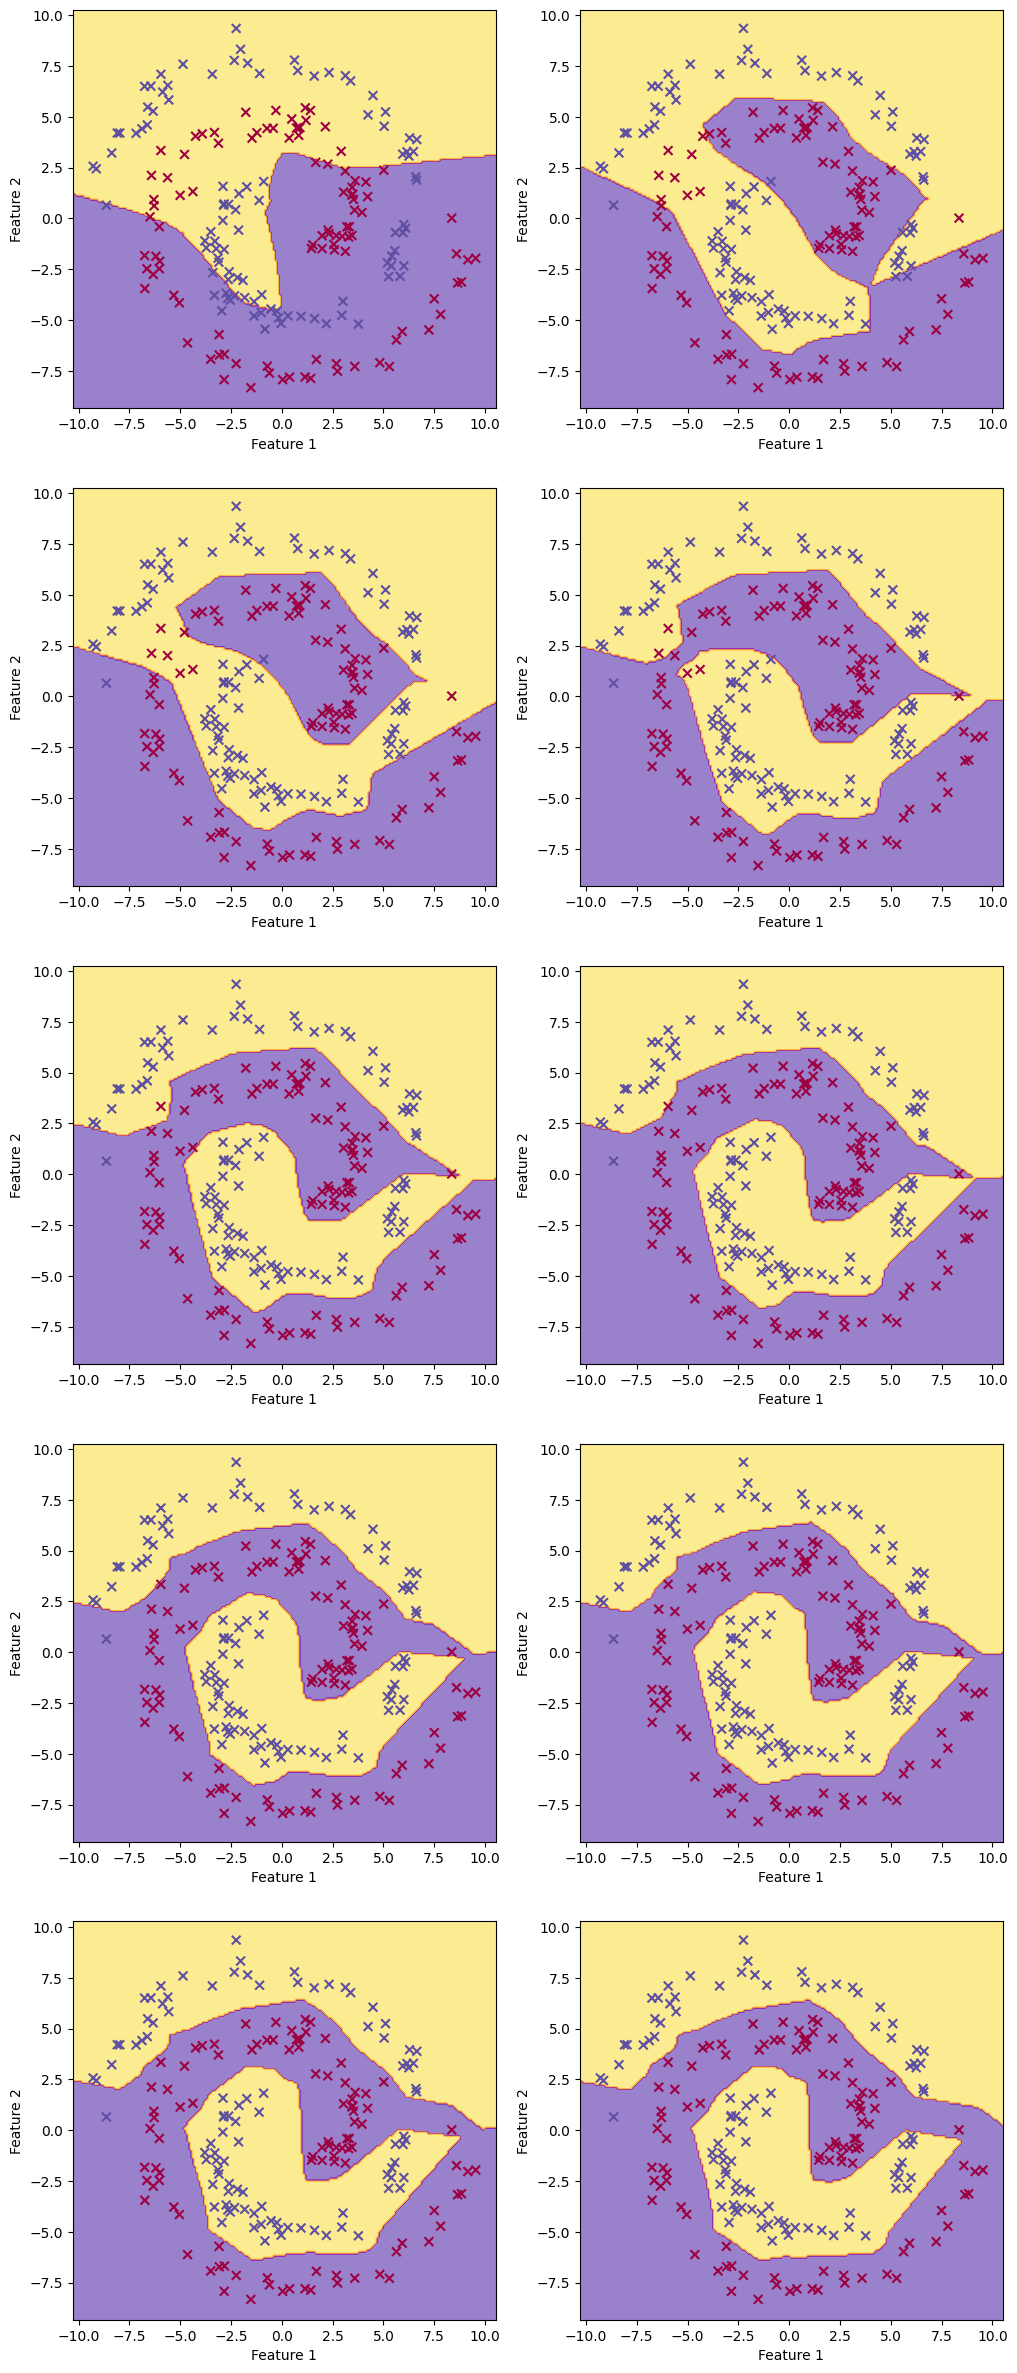

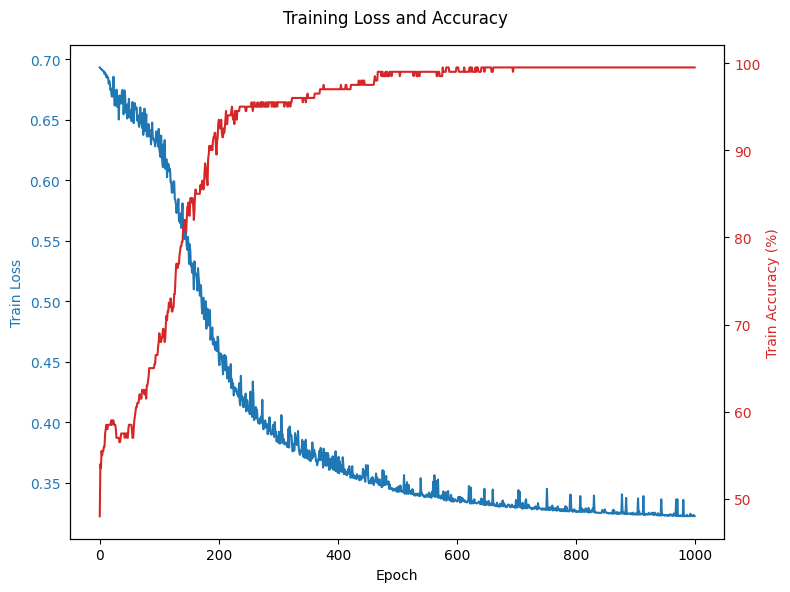

In [159]:
# Example for training the model with parameterized inputs
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Bacht size of 1 -> Stochastic Gradient Descent (SGD)

model = train_model(model, learning_rate=0.001, optimizer_fn=optim.Adam, loss_fn=nn.CrossEntropyLoss, num_epochs=1000, plot_interval=100)

<Axes: title={'center': 'Decision Boundary'}, xlabel='Feature 1', ylabel='Feature 2'>

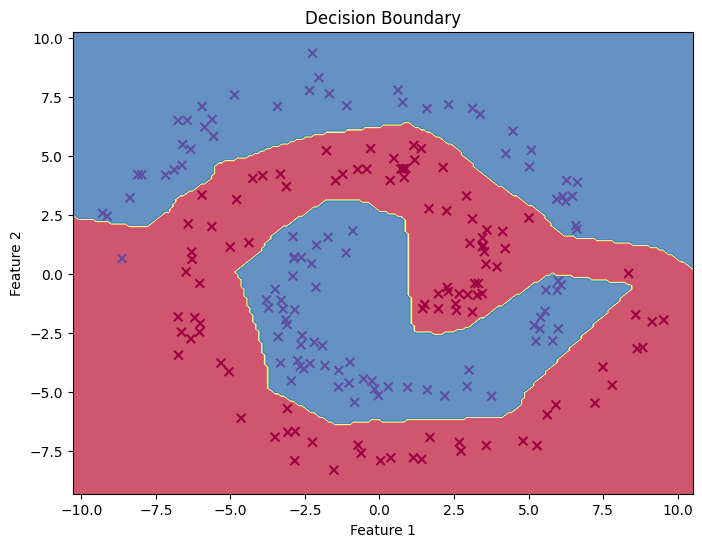

In [160]:
plot_decision_boundary(model, X, y)

# **TO DO**

--> erklären was wo wie berechnet wird

--> Aufzeigen eines Back-Propagation-Schrittes (einzelnene Berechnung darstellen) !!!!

--> Darstellen der Netz Architektur

--> Optimieren der Parameter

In [161]:
# Definiere eine anpassbare Modellklasse für den erweiterten Parametervergleich
class FlexibleNeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_layers=[10, 10], output_dim=2, activation=nn.ReLU()):

        super(FlexibleNeuralNetwork, self).__init__()
        
        # Speichere Parameter für Referenz
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.activation = activation
        
        # Erstelle die Schichten basierend auf den Parametern
        layers = []
        
        # Füge erste Schicht hinzu (input -> erste versteckte Schicht)
        prev_dim = input_dim
        
        # Füge versteckte Schichten hinzu
        for h_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(activation)
            prev_dim = h_dim
        
        # Füge die Ausgabeschicht hinzu
        layers.append(nn.Linear(prev_dim, output_dim))
        layers.append(nn.Softmax(dim=1))
        
        # Erstelle das sequenzielle Modell
        self.model = nn.Sequential(*layers)
        
        # Initialisiere die Gewichte
        self.init_weights()
    
    def init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
    
        return self.model(x)
    
    def __str__(self):
    
        return f"FlexibleNN(input={self.input_dim}, hidden={self.hidden_layers}, output={self.output_dim})"

In [162]:
# Erweiterte Trainingsfunktion für den flexiblen Parametervergleich
def train_flexible_model(model_params, training_params):

    # Erstelle ein neues Modell mit den gegebenen Parametern
    model = FlexibleNeuralNetwork(
        input_dim=model_params.get('input_dim', 2),
        hidden_layers=model_params.get('hidden_layers', [10, 10]),
        output_dim=model_params.get('output_dim', 2),
        activation=model_params.get('activation', nn.ReLU())
    )
    
    # Bereite Trainingsdaten vor
    batch_size = training_params.get('batch_size', 32)
    local_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialisiere Verlustfunktion und Optimierer
    loss_fn = training_params.get('loss_fn', nn.CrossEntropyLoss)
    criterion = loss_fn()
    optimizer = training_params.get('optimizer_fn', optim.Adam)(
        model.parameters(), 
        lr=training_params.get('learning_rate', 0.01)
    )
    
    # Training-Historie
    history = {
        'train_loss': [],
        'train_acc': []
    }
    
    # Training durchführen
    num_epochs = training_params.get('num_epochs', 100)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        
        for batch_X, batch_y in local_dataloader:
            y_pred = model(batch_X)

            if isinstance(criterion, nn.MSELoss):
                # Für MSE: Konvertiere Klassenlabels zu One-Hot-Vektoren
                y_one_hot = torch.zeros(batch_y.size(0), model_params.get('output_dim', 2))
                y_one_hot.scatter_(1, batch_y.unsqueeze(1), 1.0)
                loss = criterion(y_pred, y_one_hot)
            else:
                # Für CrossEntropy und andere: Verwende die Labels direkt
                loss = criterion(y_pred, batch_y)
                            
            epoch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                predictions = torch.argmax(y_pred, dim=1)
                correct += (predictions == batch_y).sum().item()
        
        # Berechne durchschnittlichen Verlust und Genauigkeit
        train_loss = epoch_loss / len(local_dataloader)
        accuracy = 100 * correct / len(dataset)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(accuracy)
        
        # Fortschritt ausgeben
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return model, history

In [163]:
# Definiere verschiedene Modellarchitekturen
architectures = [
    {
        'name': 'Flaches Netz [10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Standard [10, 10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Tief [10, 10, 10]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Breit [20, 20]',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [20, 20],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    }
]

# Definiere verschiedene Aktivierungsfunktionen
activation_functions = [
    {
        'name': 'ReLU',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.ReLU()
        }
    },
    {
        'name': 'Sigmoid',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.Sigmoid()
        }
    },
    {
        'name': 'Tanh',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.Tanh()
        }
    },
    {
        'name': 'LeakyReLU',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],
            'output_dim': 2,
            'activation': nn.LeakyReLU(0.1)
        }
    }
]

# Definiere verschiedene Optimierer und Lernraten
optimizers = [
    {
        'name': 'Adam LR=0.01',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'SGD LR=0.01',
        'training_params': {
            'optimizer_fn': optim.SGD,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'RMSprop LR=0.01',
        'training_params': {
            'optimizer_fn': optim.RMSprop,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'Adam LR=0.001',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.001,
            'batch_size': 32,
            'num_epochs': 200
        }
    }
]

loss_functions = [
    {
        'name': 'CrossEntropy',
        'training_params': {
            'loss_fn': nn.CrossEntropyLoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },    
    {
        'name': 'MSE',
        'training_params': {
            'loss_fn': nn.MSELoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
]

# Definiere verschiedene Batch-Größen
batch_sizes = [
    {
        'name': 'Batch Size=8',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 8,
            'num_epochs': 200
        }
    },
    {
        'name': 'Batch Size=32',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 32,
            'num_epochs': 200
        }
    },
    {
        'name': 'Batch Size=64',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': 64,
            'num_epochs': 200
        }
    },
    {
        'name': 'Full Batch',
        'training_params': {
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,
            'batch_size': len(dataset),
            'num_epochs': 200
        }
    }
]

In [164]:
# Funktion zum Vergleichen einer bestimmten Parametergruppe
def compare_parameter_group(parameter_group, default_model_params={}, default_training_params={}):
    
    results = []
    
    # Standardwerte festlegen
    std_model_params = {
        'input_dim': 2,
        'hidden_layers': [10, 10],
        'output_dim': 2,
        'activation': nn.ReLU()
    }
    std_model_params.update(default_model_params)
    
    std_training_params = {
        'optimizer_fn': optim.Adam,
        'learning_rate': 0.01,
        'batch_size': 32,
        'loss_fn': nn.CrossEntropyLoss,
        'num_epochs': 200
    }
    std_training_params.update(default_training_params)
    
    # Für jedes Parameter-Set in der Gruppe
    for params in parameter_group:
        print(f"\nTraining mit {params['name']}...")
        
        # Modell- und Trainingsparameter zusammenführen
        model_params = std_model_params.copy()
        training_params = std_training_params.copy()
        
        if 'model_params' in params:
            model_params.update(params['model_params'])
        
        if 'training_params' in params:
            training_params.update(params['training_params'])
        
        # Trainiere das Modell mit den aktuellen Parametern
        trained_model, history = train_flexible_model(model_params, training_params)
        
        # Speichere die Ergebnisse
        res = {
            'params': params,
            'model': trained_model,
            'history': history
        }
        results.append(res)
        
        print(f"Training für {params['name']} abgeschlossen! Finale Genauigkeit: {history['train_acc'][-1]:.2f}%")
    
    return results

In [165]:
# Funktion zum Visualisieren der Ergebnisse
def visualize_results(results, title="Parametervergleich"):

    n = len(results)
    if n == 0:
        print("Keine Ergebnisse zum Visualisieren.")
        return
    
    # Visualisiere die Trainingskurven
    plt.figure(figsize=(15, 10))
    
    # Plot Loss
    plt.subplot(2, 1, 1)
    for res in results:
        plt.plot(res['history']['train_loss'], label=res['params']['name'])
    plt.title(f'{title}: Vergleich des Trainingsverlusts')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(2, 1, 2)
    for res in results:
        plt.plot(res['history']['train_acc'], label=res['params']['name'])
    plt.title(f'{title}: Vergleich der Trainingsgenauigkeit')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Visualisiere nur die finalen Decision Boundaries in einem 2x2 Grid
    # Unabhängig von der Anzahl der Modelle verwenden wir ein 2x2 Layout für Konsistenz
    rows, cols = 2, 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
    axes = axes.flatten()  # Flatten für einfacheren Zugriff
    
    # Überschrift für die gesamte Grafik
    fig.suptitle(f'Decision Boundary: {title}', fontsize=16)
    
    # Für jedes Ergebnis eine Entscheidungsgrenze plotten
    for i, res in enumerate(results):
        if i < rows * cols:  # Nur so viele plotten, wie in das Grid passen
            ax = axes[i]
            plot_decision_boundary(res['model'], X, y, ax=ax, title=f"Decision Boundary: {res['params']['name']}")
    
    # Verstecke nicht benötigte Subplots
    for i in range(len(results), rows * cols):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Platz für den Haupttitel
    plt.show()


Training mit Flaches Netz [10]...
Epoch [50/200], Loss: 0.5145, Accuracy: 82.50%
Epoch [100/200], Loss: 0.4233, Accuracy: 93.00%
Epoch [150/200], Loss: 0.4113, Accuracy: 93.50%
Epoch [200/200], Loss: 0.3985, Accuracy: 93.00%
Training für Flaches Netz [10] abgeschlossen! Finale Genauigkeit: 93.00%

Training mit Standard [10, 10]...
Epoch [50/200], Loss: 0.4423, Accuracy: 86.50%
Epoch [100/200], Loss: 0.3746, Accuracy: 94.00%
Epoch [150/200], Loss: 0.3973, Accuracy: 91.00%
Epoch [200/200], Loss: 0.3924, Accuracy: 94.50%
Training für Standard [10, 10] abgeschlossen! Finale Genauigkeit: 94.50%

Training mit Tief [10, 10, 10]...
Epoch [50/200], Loss: 0.3655, Accuracy: 94.50%
Epoch [100/200], Loss: 0.3622, Accuracy: 95.00%
Epoch [150/200], Loss: 0.3317, Accuracy: 98.00%
Epoch [200/200], Loss: 0.3448, Accuracy: 98.00%
Training für Tief [10, 10, 10] abgeschlossen! Finale Genauigkeit: 98.00%

Training mit Breit [20, 20]...
Epoch [50/200], Loss: 0.3368, Accuracy: 98.50%
Epoch [100/200], Loss: 0

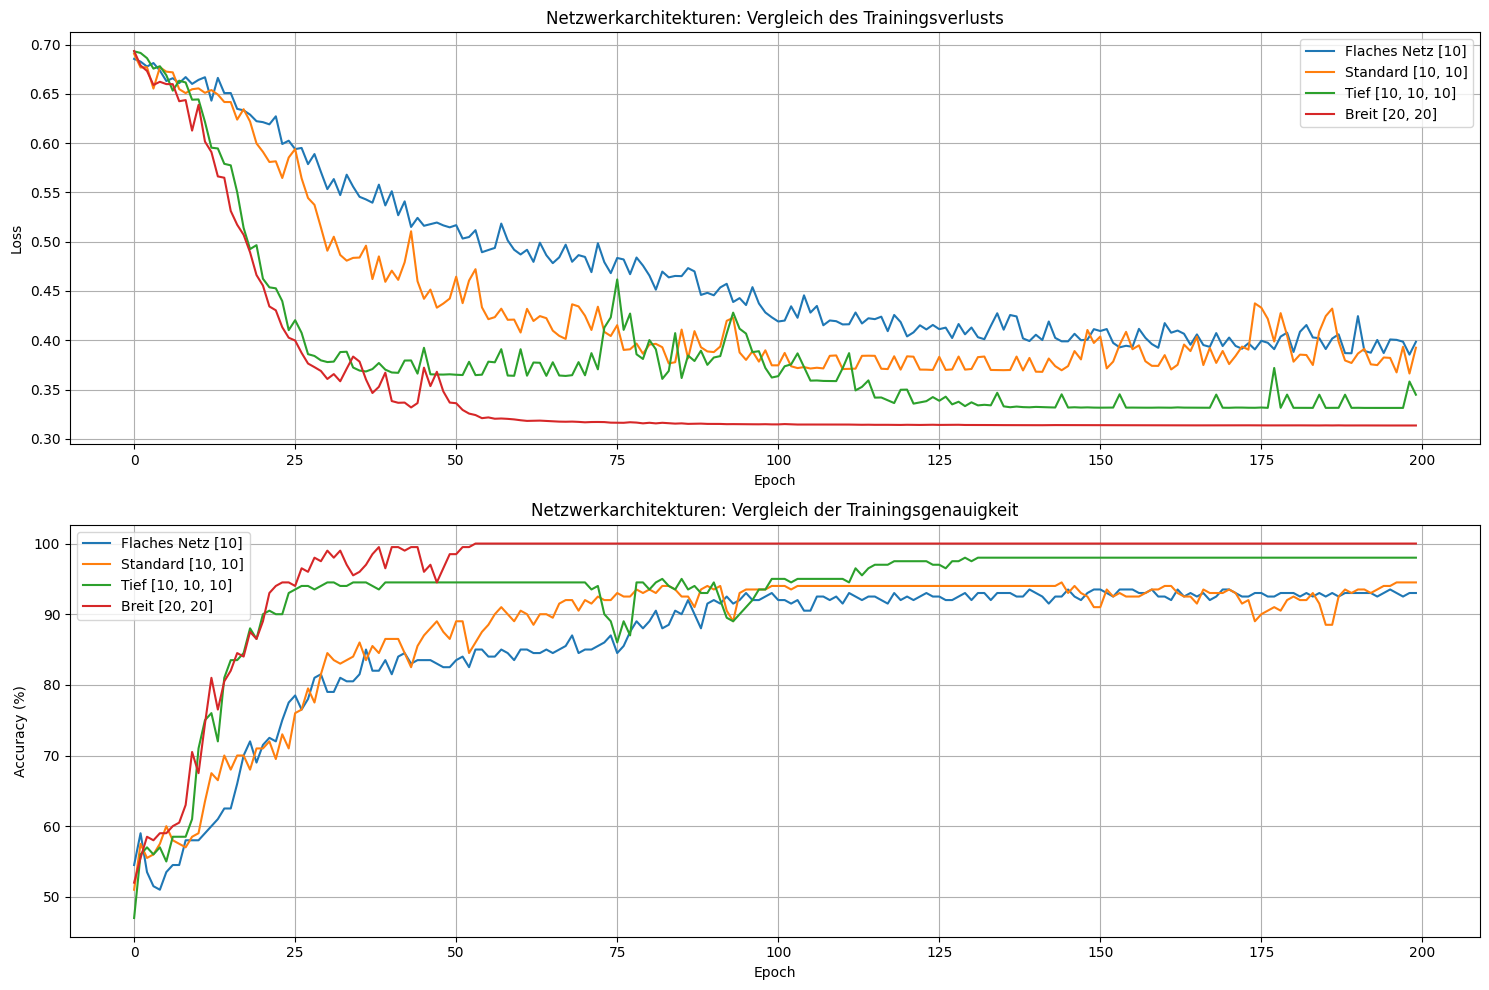

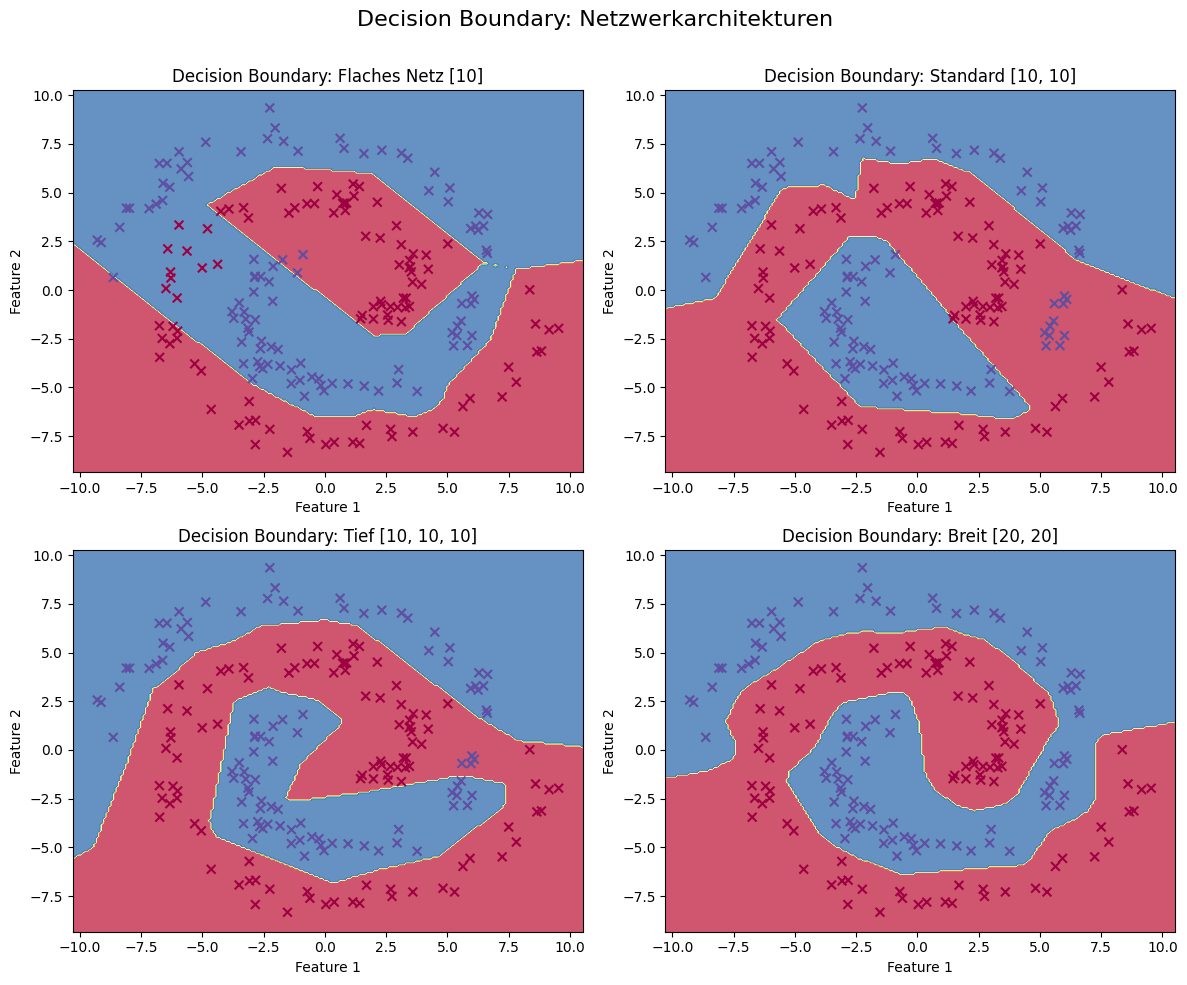

In [166]:
arch_results = compare_parameter_group(architectures)
visualize_results(arch_results, "Netzwerkarchitekturen")


Training mit ReLU...
Epoch [50/200], Loss: 0.4713, Accuracy: 91.00%
Epoch [100/200], Loss: 0.3751, Accuracy: 94.50%
Epoch [150/200], Loss: 0.3515, Accuracy: 97.00%
Epoch [200/200], Loss: 0.3166, Accuracy: 100.00%
Training für ReLU abgeschlossen! Finale Genauigkeit: 100.00%

Training mit Sigmoid...
Epoch [50/200], Loss: 0.6292, Accuracy: 69.00%
Epoch [100/200], Loss: 0.5315, Accuracy: 80.50%
Epoch [150/200], Loss: 0.5278, Accuracy: 79.50%
Epoch [200/200], Loss: 0.5167, Accuracy: 78.50%
Training für Sigmoid abgeschlossen! Finale Genauigkeit: 78.50%

Training mit Tanh...
Epoch [50/200], Loss: 0.5065, Accuracy: 81.50%
Epoch [100/200], Loss: 0.4984, Accuracy: 83.50%
Epoch [150/200], Loss: 0.4663, Accuracy: 84.00%
Epoch [200/200], Loss: 0.4668, Accuracy: 84.50%
Training für Tanh abgeschlossen! Finale Genauigkeit: 84.50%

Training mit LeakyReLU...
Epoch [50/200], Loss: 0.3972, Accuracy: 93.00%
Epoch [100/200], Loss: 0.3945, Accuracy: 94.00%
Epoch [150/200], Loss: 0.3575, Accuracy: 95.00%
Epo

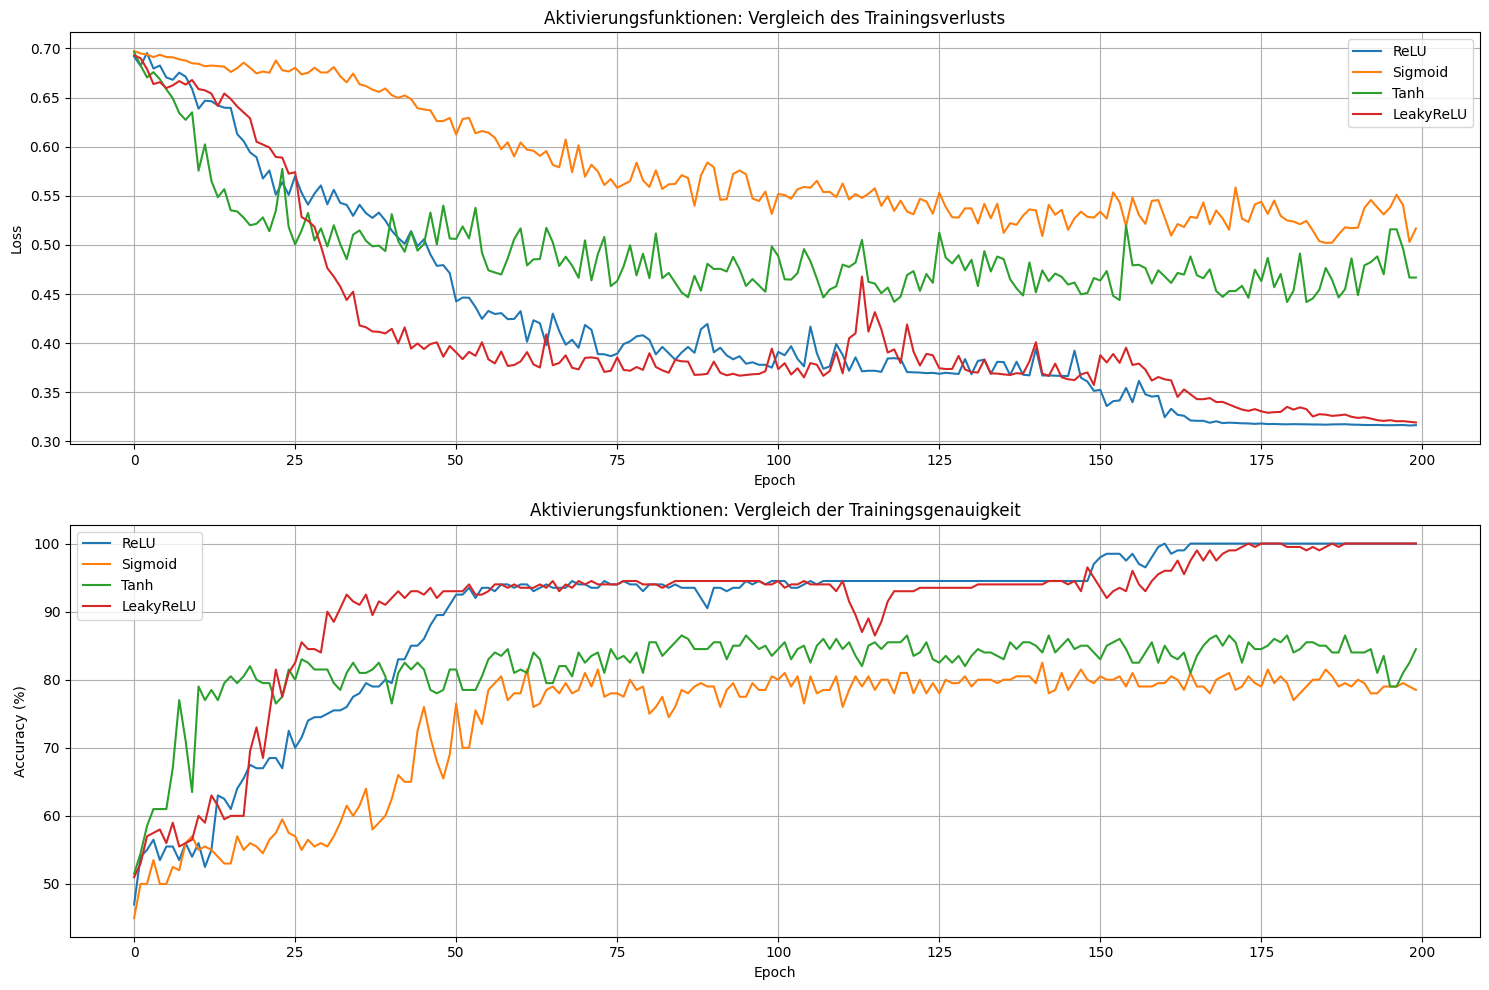

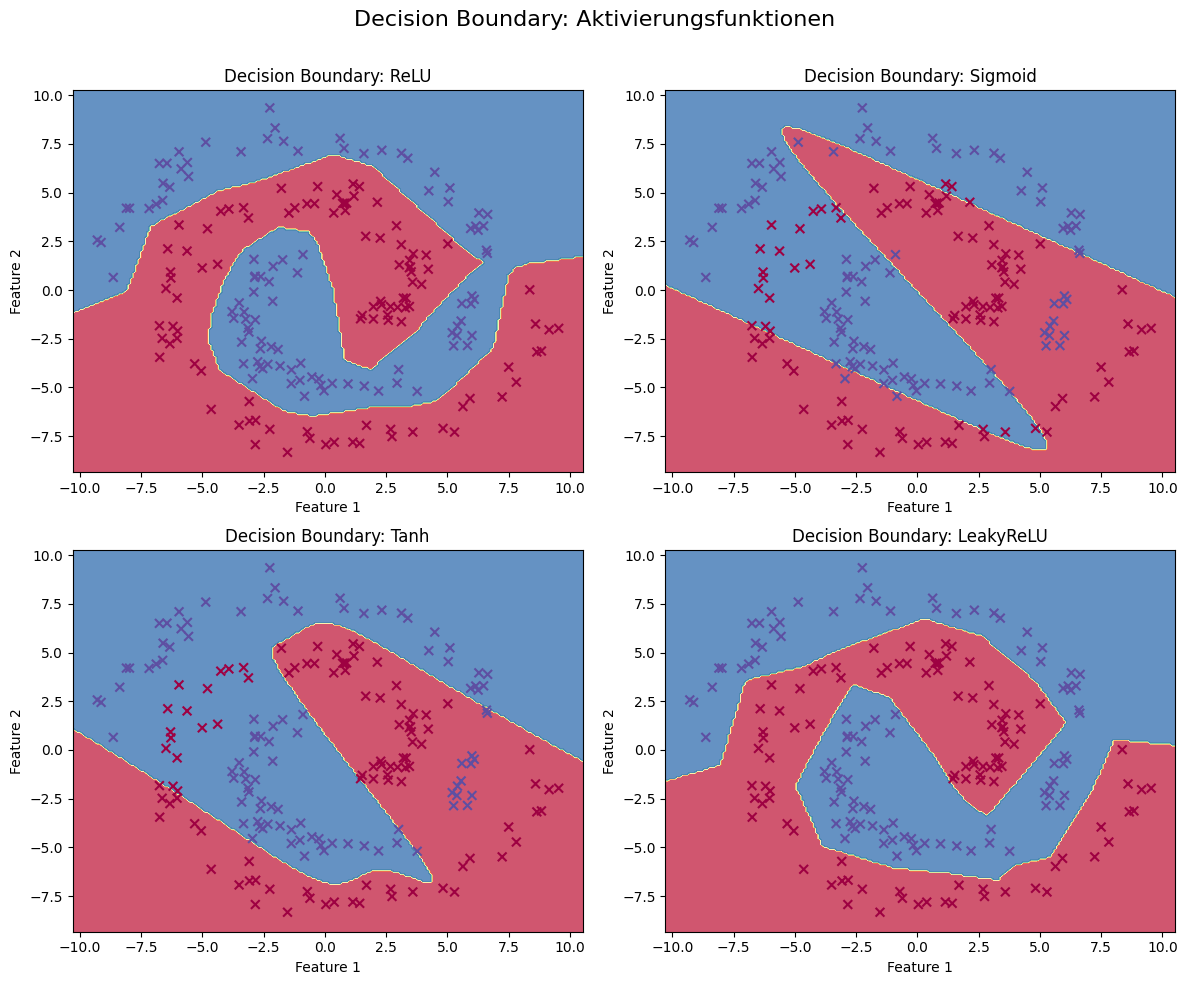

In [167]:
act_results = compare_parameter_group(activation_functions)
visualize_results(act_results, "Aktivierungsfunktionen")


Training mit Adam LR=0.01...
Epoch [50/200], Loss: 0.4568, Accuracy: 92.50%
Epoch [100/200], Loss: 0.3797, Accuracy: 95.50%
Epoch [150/200], Loss: 0.3228, Accuracy: 99.50%
Epoch [200/200], Loss: 0.3451, Accuracy: 97.50%
Training für Adam LR=0.01 abgeschlossen! Finale Genauigkeit: 97.50%

Training mit SGD LR=0.01...
Epoch [50/200], Loss: 0.6928, Accuracy: 50.50%
Epoch [100/200], Loss: 0.6908, Accuracy: 54.00%
Epoch [150/200], Loss: 0.6881, Accuracy: 55.00%
Epoch [200/200], Loss: 0.6840, Accuracy: 55.00%
Training für SGD LR=0.01 abgeschlossen! Finale Genauigkeit: 55.00%

Training mit RMSprop LR=0.01...
Epoch [50/200], Loss: 0.4024, Accuracy: 93.50%
Epoch [100/200], Loss: 0.3676, Accuracy: 94.50%
Epoch [150/200], Loss: 0.3650, Accuracy: 94.50%
Epoch [200/200], Loss: 0.3762, Accuracy: 94.50%
Training für RMSprop LR=0.01 abgeschlossen! Finale Genauigkeit: 94.50%

Training mit Adam LR=0.001...
Epoch [50/200], Loss: 0.6698, Accuracy: 59.00%
Epoch [100/200], Loss: 0.6256, Accuracy: 68.00%
Epo

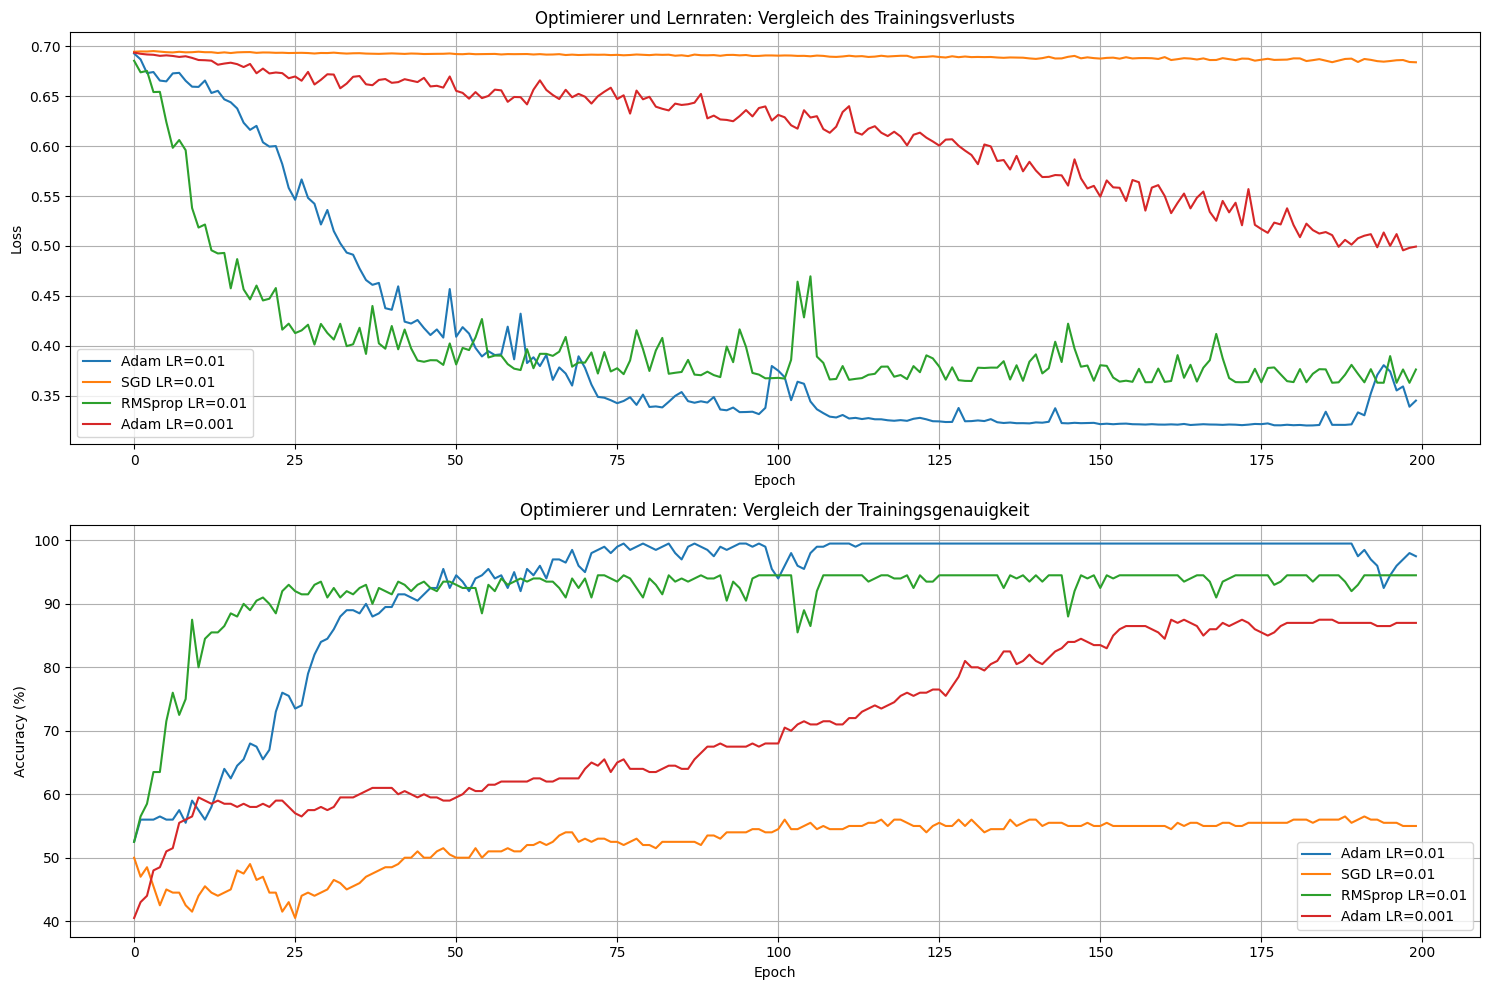

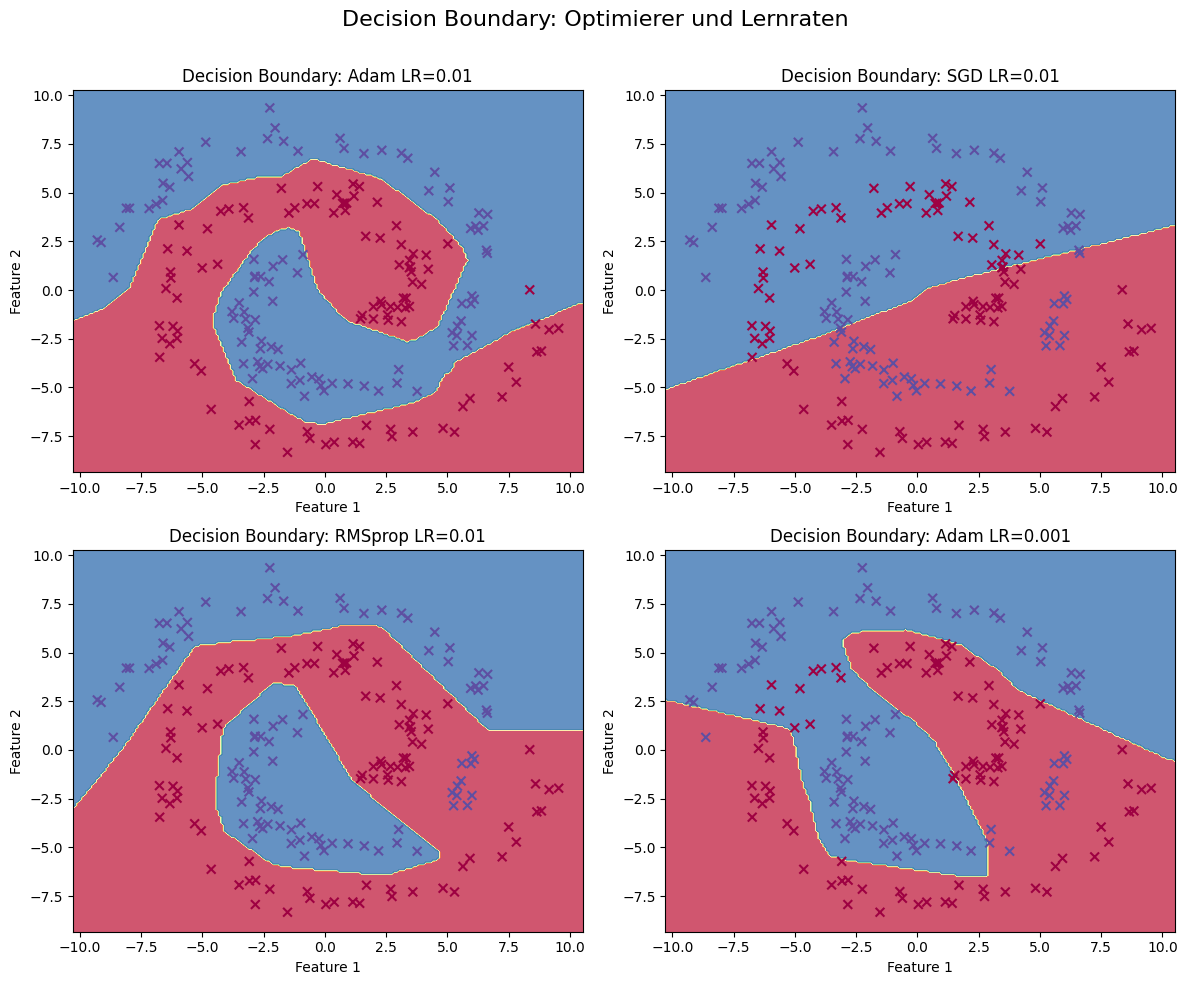

In [168]:
optimizer_results = compare_parameter_group(optimizers)
visualize_results(optimizer_results, "Optimierer und Lernraten")


Training mit CrossEntropy...
Epoch [50/200], Loss: 0.3878, Accuracy: 95.50%
Epoch [100/200], Loss: 0.3251, Accuracy: 99.50%
Epoch [150/200], Loss: 0.3196, Accuracy: 99.50%
Epoch [200/200], Loss: 0.3146, Accuracy: 100.00%
Training für CrossEntropy abgeschlossen! Finale Genauigkeit: 100.00%

Training mit MSE...
Epoch [50/200], Loss: 0.0179, Accuracy: 99.00%
Epoch [100/200], Loss: 0.0031, Accuracy: 100.00%
Epoch [150/200], Loss: 0.0012, Accuracy: 100.00%
Epoch [200/200], Loss: 0.0026, Accuracy: 100.00%
Training für MSE abgeschlossen! Finale Genauigkeit: 100.00%


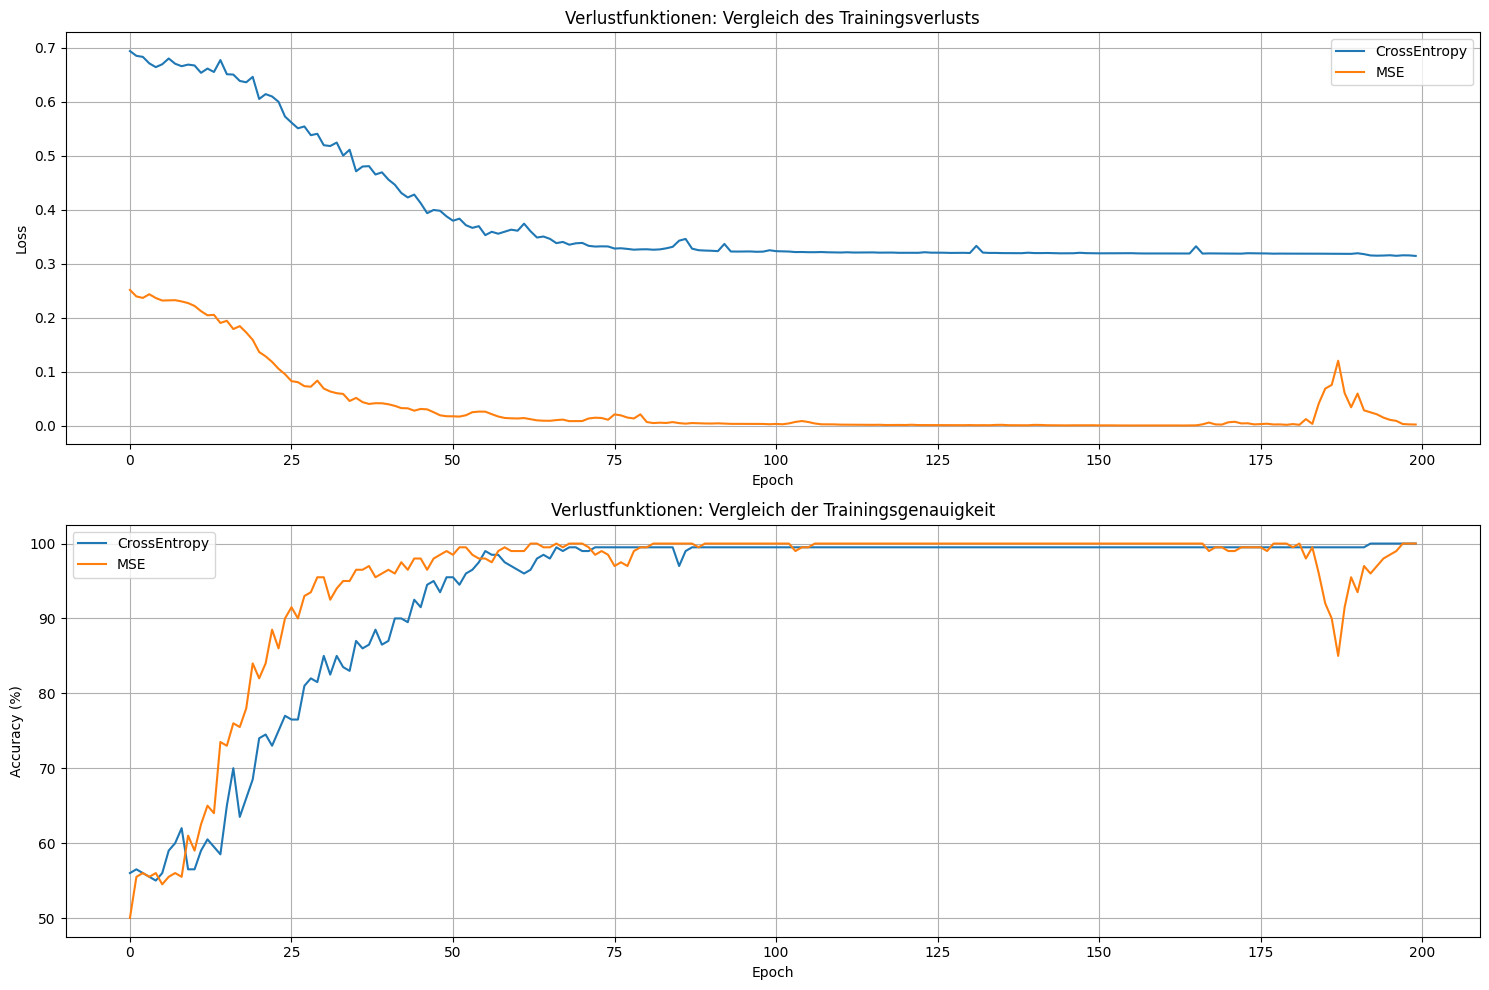

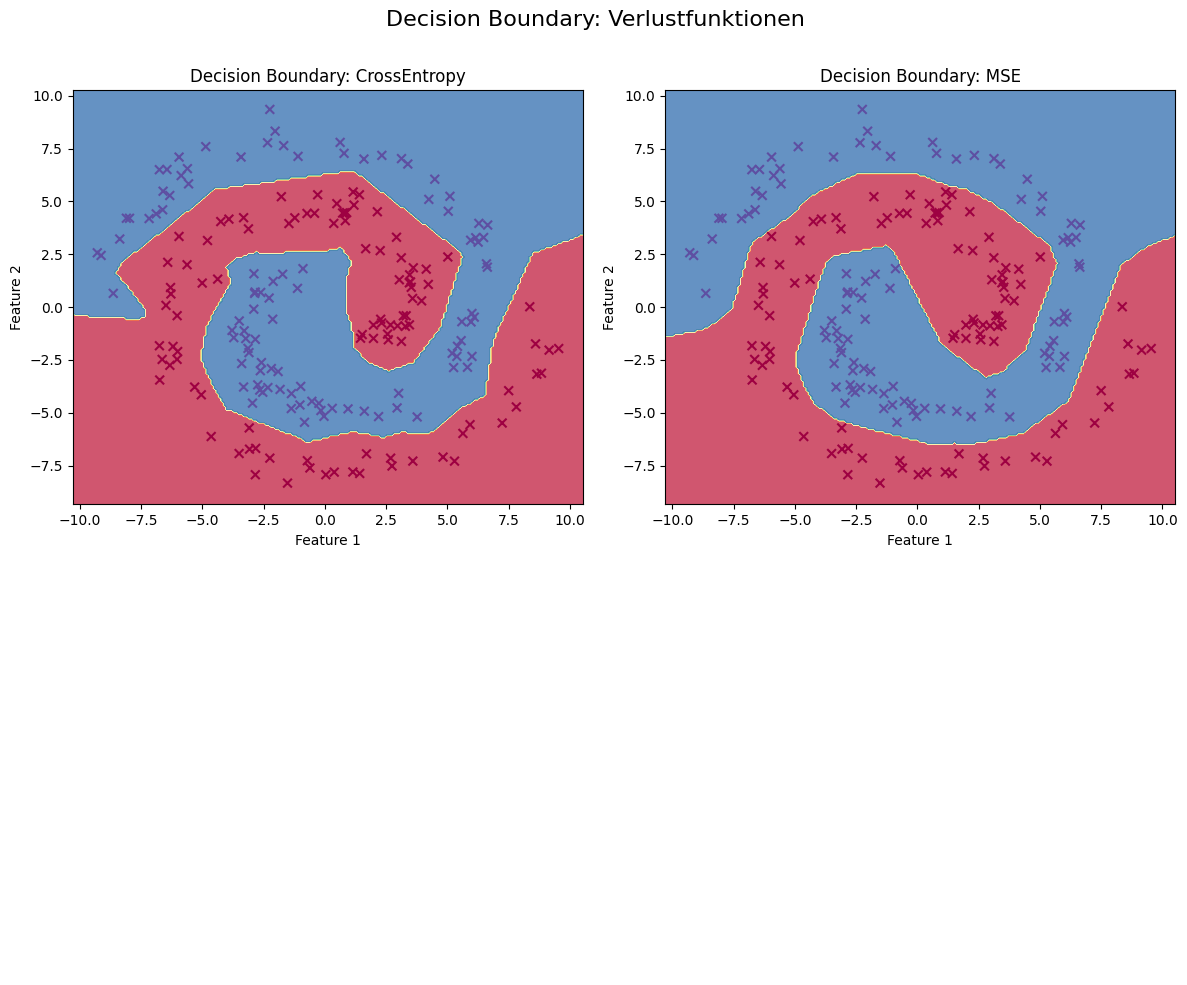

In [169]:
loss_results = compare_parameter_group(loss_functions)
visualize_results(loss_results, "Verlustfunktionen")


Training mit Batch Size=8...
Epoch [50/200], Loss: 0.3943, Accuracy: 93.00%
Epoch [100/200], Loss: 0.3817, Accuracy: 93.00%
Epoch [150/200], Loss: 0.3732, Accuracy: 94.00%
Epoch [200/200], Loss: 0.3686, Accuracy: 94.50%
Training für Batch Size=8 abgeschlossen! Finale Genauigkeit: 94.50%

Training mit Batch Size=32...
Epoch [50/200], Loss: 0.5799, Accuracy: 71.00%
Epoch [100/200], Loss: 0.4110, Accuracy: 90.50%
Epoch [150/200], Loss: 0.3763, Accuracy: 93.00%
Epoch [200/200], Loss: 0.3488, Accuracy: 96.00%
Training für Batch Size=32 abgeschlossen! Finale Genauigkeit: 96.00%

Training mit Batch Size=64...
Epoch [50/200], Loss: 0.4572, Accuracy: 91.50%
Epoch [100/200], Loss: 0.3824, Accuracy: 92.00%
Epoch [150/200], Loss: 0.3644, Accuracy: 94.50%
Epoch [200/200], Loss: 0.3608, Accuracy: 94.50%
Training für Batch Size=64 abgeschlossen! Finale Genauigkeit: 94.50%

Training mit Full Batch...
Epoch [50/200], Loss: 0.5918, Accuracy: 77.50%
Epoch [100/200], Loss: 0.4382, Accuracy: 89.00%
Epoch 

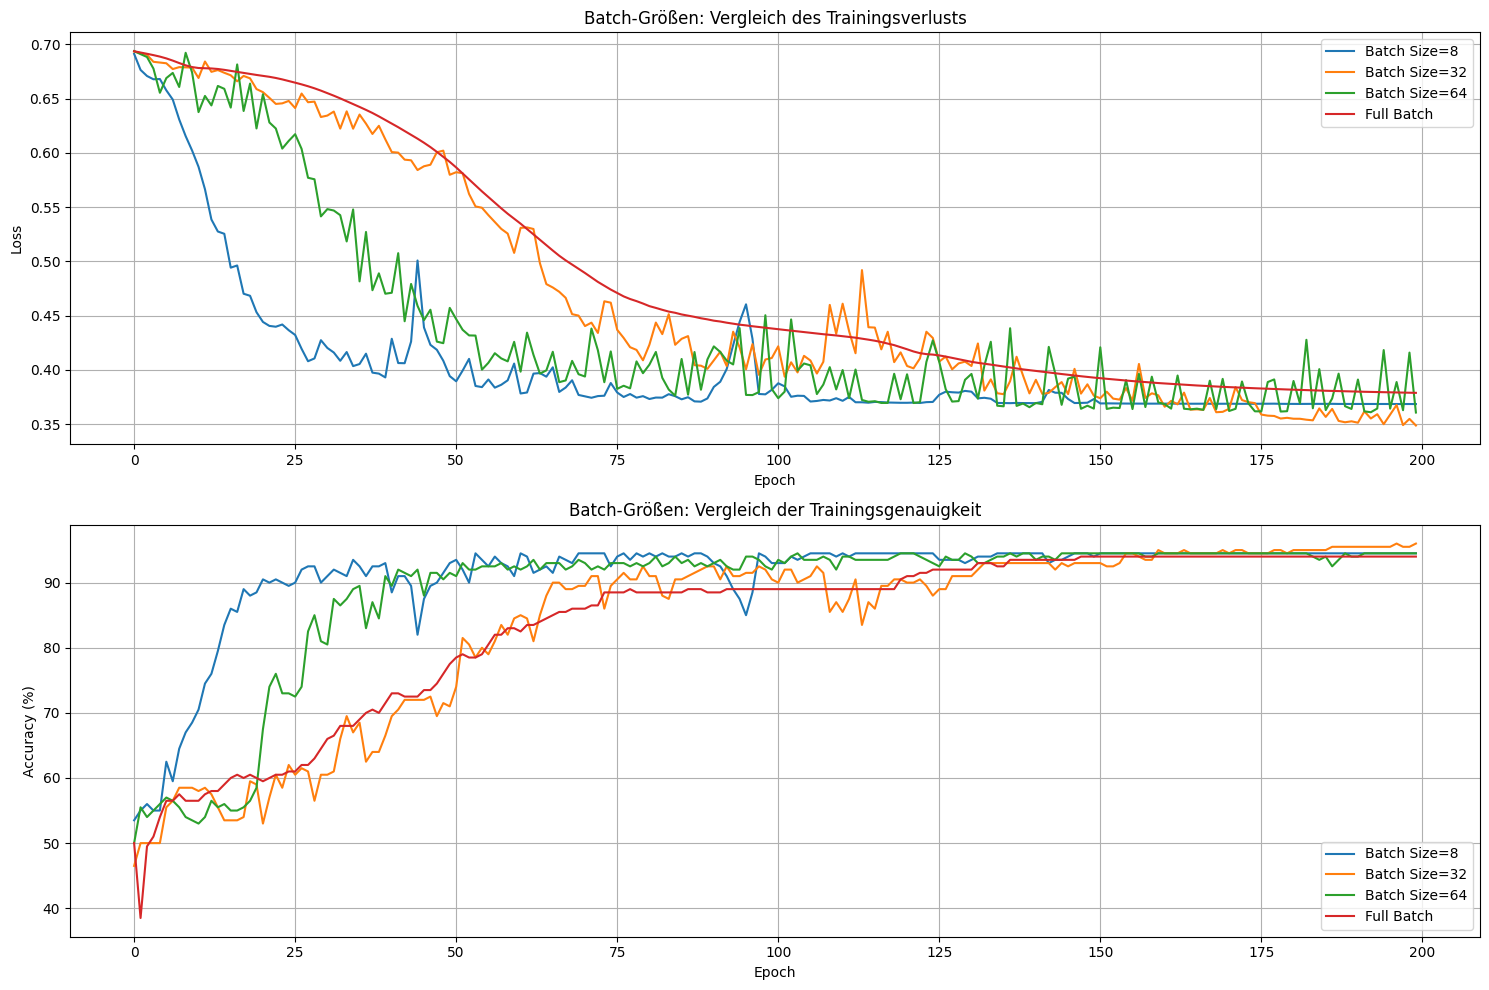

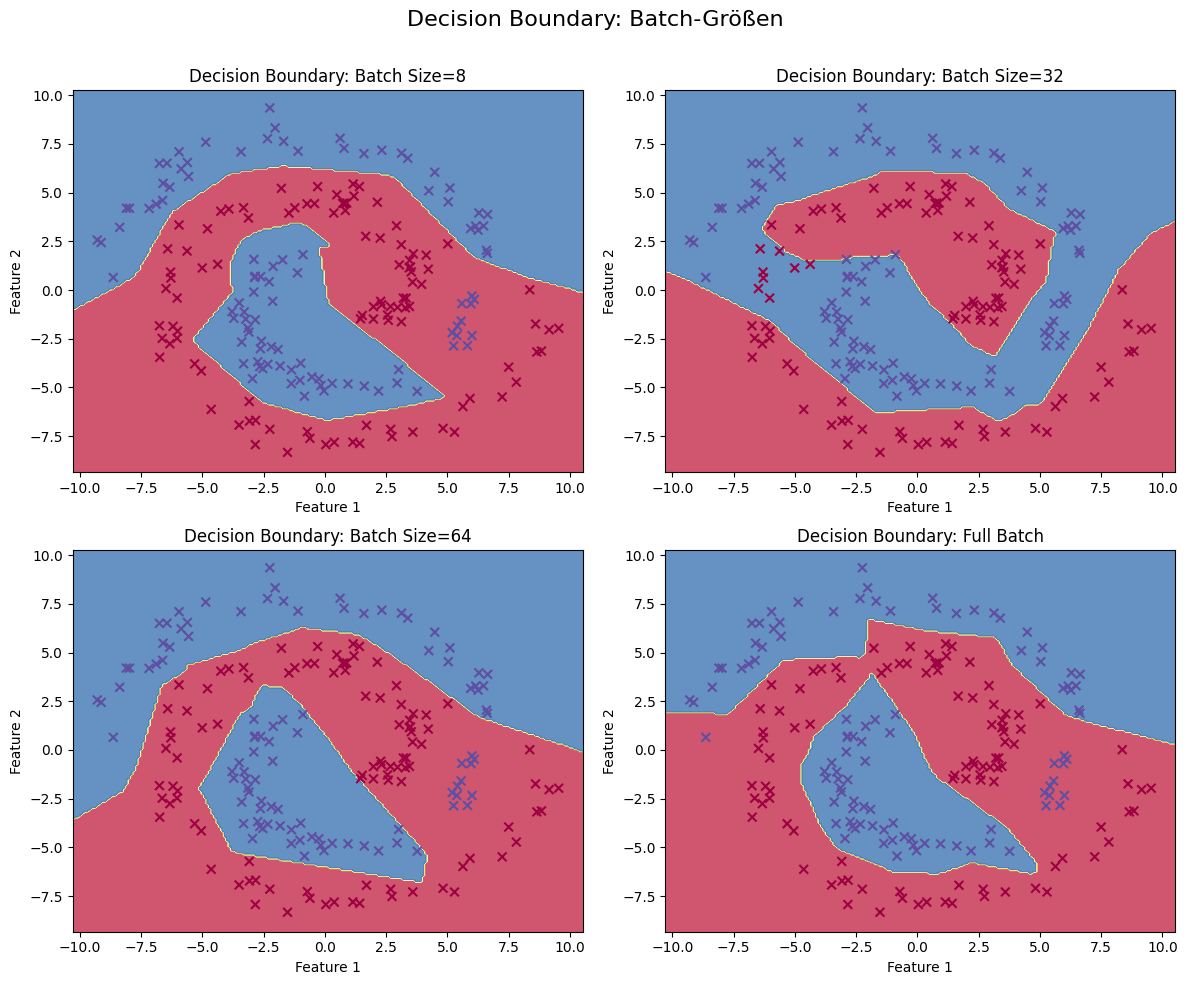

In [170]:
batch_results = compare_parameter_group(batch_sizes)
visualize_results(batch_results, "Batch-Größen")

In [173]:
#Eigene Parameterkombination erstellen
custom_params = [
    {
        'name': 'Perfektes Modell',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [10, 10],  
            'output_dim': 2,
            'activation': nn.ReLU()
        },
        'training_params': {
            'loss_fn': nn.MSELoss,
            'optimizer_fn': optim.Adam,
            'learning_rate': 0.01,     
            'batch_size': 64,           
            'num_epochs': 200          
        }
    },
    {
        'name': 'Custom Modell',
        'model_params': {
            'input_dim': 2,
            'hidden_layers': [20, 10, 5],  
            'output_dim': 2,
            'activation': nn.LeakyReLU(0.05)  
        },
        'training_params': {
            'loss_fn': nn.CrossEntropyLoss,
            'optimizer_fn': optim.RMSprop,
            'learning_rate': 0.002,
            'batch_size': 32,
            'num_epochs': 200
        }
    }
]


Training mit Perfektes Modell...
Epoch [50/200], Loss: 0.0843, Accuracy: 89.00%
Epoch [100/200], Loss: 0.0164, Accuracy: 99.50%
Epoch [150/200], Loss: 0.0040, Accuracy: 100.00%
Epoch [200/200], Loss: 0.0013, Accuracy: 100.00%
Training für Perfektes Modell abgeschlossen!

Training mit Custom Modell...
Epoch [50/200], Loss: 0.6084, Accuracy: 74.50%
Epoch [100/200], Loss: 0.4943, Accuracy: 86.50%
Epoch [150/200], Loss: 0.4329, Accuracy: 88.00%
Epoch [200/200], Loss: 0.4055, Accuracy: 90.50%
Training für Custom Modell abgeschlossen!


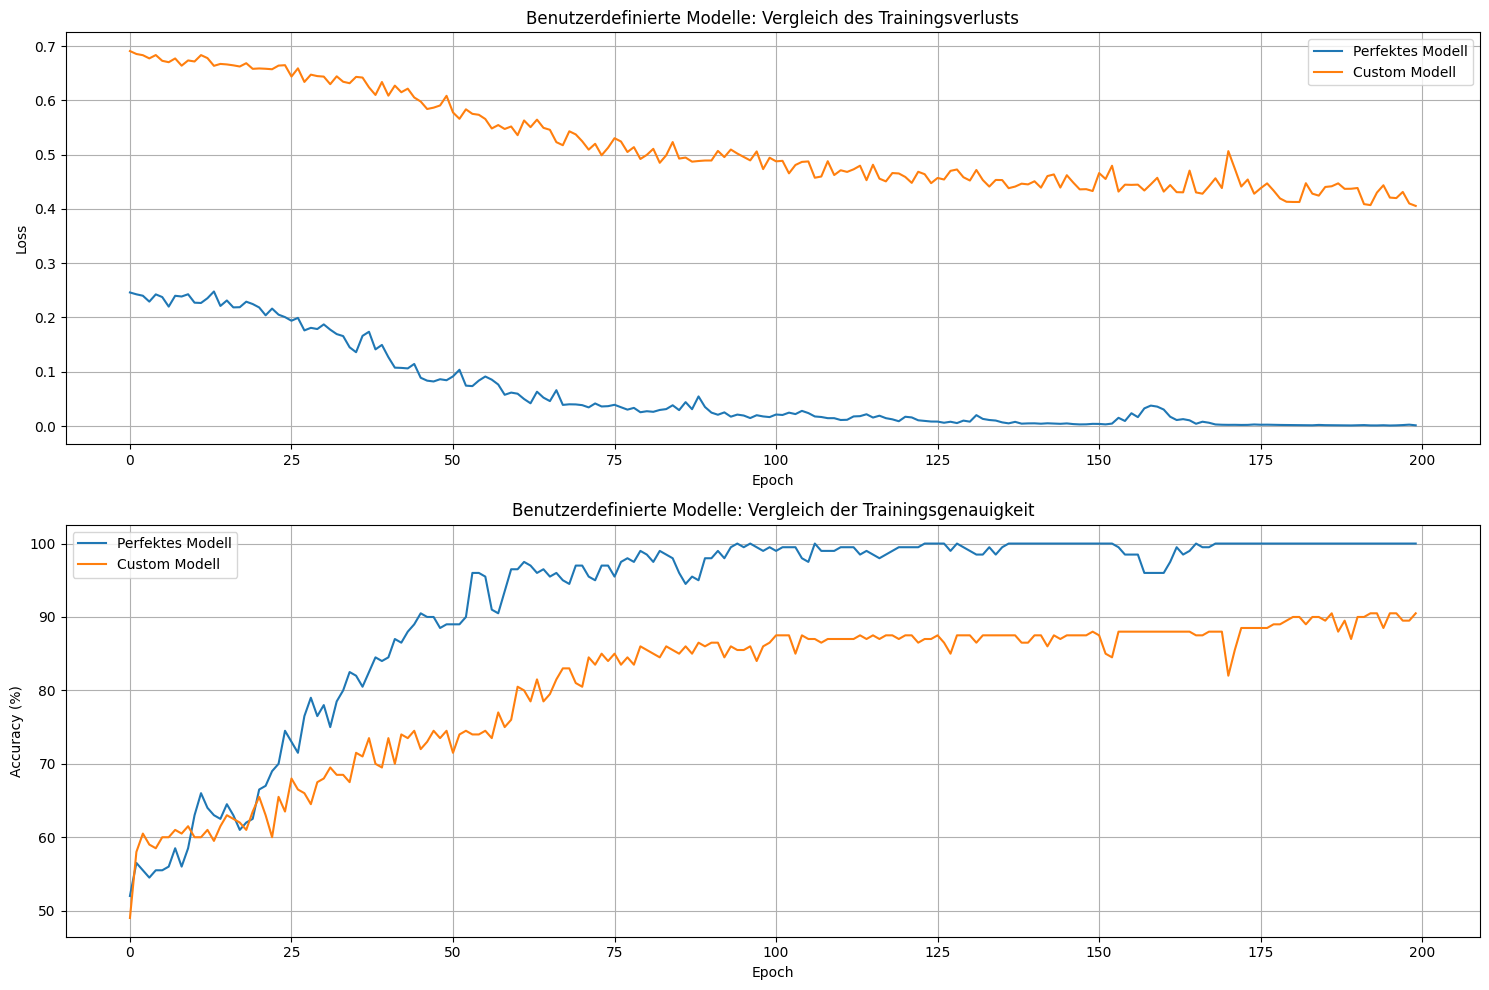

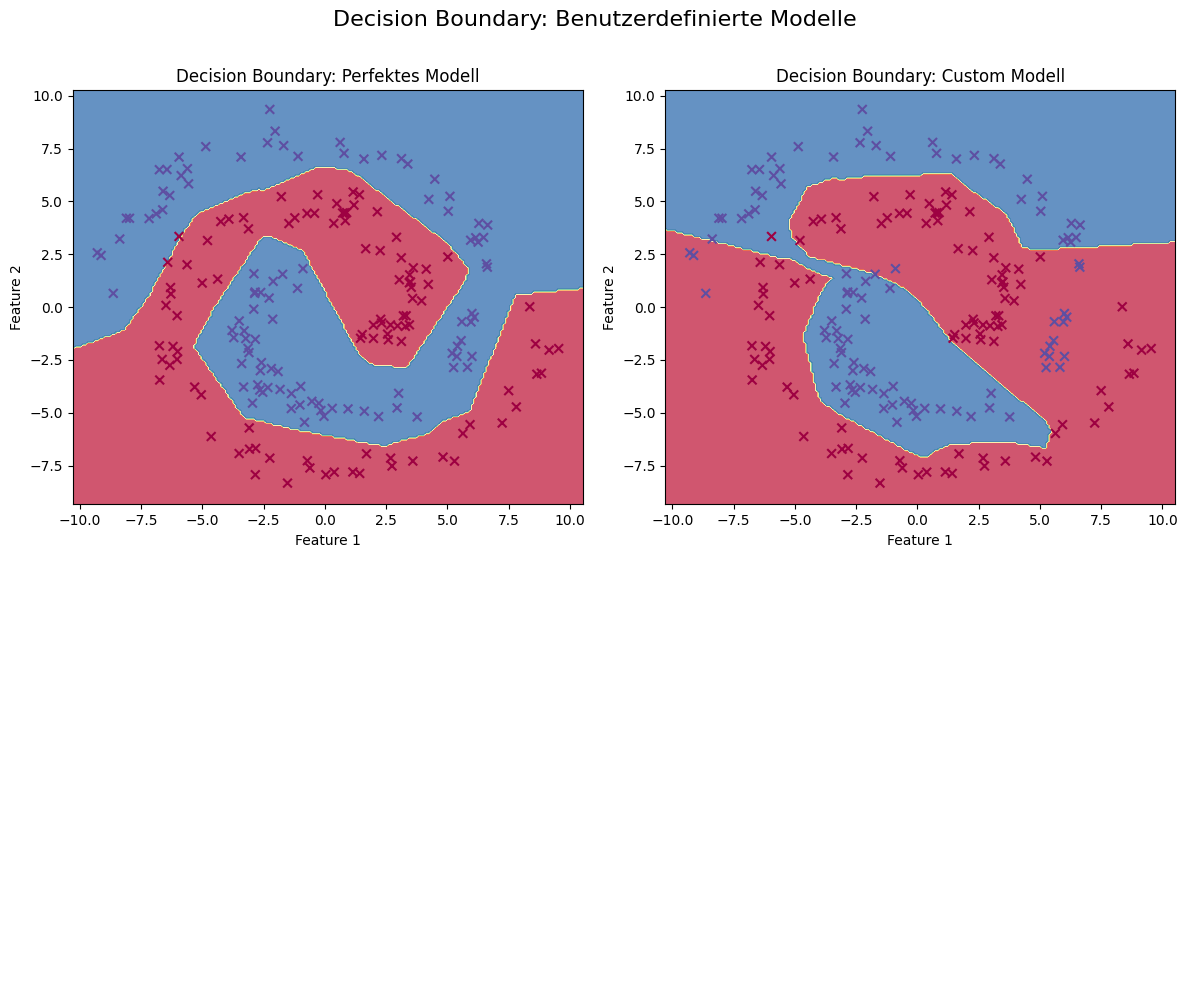

In [174]:
custom_results = []
for param_set in custom_params:
    print(f"\nTraining mit {param_set['name']}...")
    model, history = train_flexible_model(
        param_set.get('model_params', {}),
        param_set.get('training_params', {})
    )
    custom_results.append({
        'params': param_set,
        'model': model,
        'history': history
    })
    print(f"Training für {param_set['name']} abgeschlossen!")

visualize_results(custom_results, "Benutzerdefinierte Modelle")